In [1]:
# Autoreload packages that are modified
%load_ext autoreload
%autoreload 2

import collections
from datetime import datetime, timedelta
import glob
import os
import sys
import time
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cartopy.crs as ccrs
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd

from data import get_data
from utils import plot_forecast, plot_components

cwd = os.getcwd()
sys.path.append(f"{cwd}/forecast_rodeo")
sys.path.append(f"{cwd}/forecast_rodeo/src/experiments")

In [2]:
# https://stackoverflow.com/questions/43147983/could-not-create-cudnn-handle-cudnn-status-internal-error
# physical_devices = tf.config.experimental.list_physical_devices('GPU')
# assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
# config = tf.config.experimental.set_memory_growth(physical_devices[0], True)

## Get the data

In [3]:
num_forecast_steps = 7 * 4 # 28 days

X, anoms, clims, temps, dates, \
columnstr_to_index, index_to_columnstr = get_data()

num_data_to_consider = 365 * 10 # 10 years worth of data
assert(num_data_to_consider > num_forecast_steps)

X_train = X[-num_data_to_consider:-num_forecast_steps, :]
anoms_train = anoms[-num_data_to_consider:-num_forecast_steps]
clims_train = clims[-num_data_to_consider:-num_forecast_steps]
temps_train = temps[-num_data_to_consider:-num_forecast_steps]
dates_train = dates[-num_data_to_consider:-num_forecast_steps]

X_test = X[-num_forecast_steps:, :]
anoms_test = anoms[-num_forecast_steps:]
clims_test = clims[-num_forecast_steps:]
temps_test = temps[-num_forecast_steps:]
dates_test = dates[-num_forecast_steps:]

is_predicting_anomaly = False
if is_predicting_anomaly:
    Y_train = anoms_train
    Y_test = anoms_test
    print(f"Y is temperature anomaly!")
else:
    Y_train = temps_train
    Y_test = temps_test
    print(f"Y is temperature directly!")


['forecast_rodeo/results/regression/shared/contest_tmp2m_34w/lat_lon_date_data-contest_tmp2m_34w.h5', 'forecast_rodeo/results/regression/shared/contest_tmp2m_34w/date_data-contest_tmp2m_34w.h5']
lat_oi: 27.0, lon_oi: 261.0
Y is temperature directly!


In [4]:
print(clims.shape)

(13283,)


In [5]:
years_in_data = dates.dt.year
first_year = min(years_in_data)
last_year = max(years_in_data)
print(first_year)
print(last_year)

print(index_to_columnstr)

num_forecast_steps = 7 * 4 # 28 days

1982
2018
{0: 'tmp2m_shift29', 1: 'tmp2m_shift29_anom', 2: 'tmp2m_shift58', 3: 'tmp2m_shift58_anom', 4: 'rhum_shift30', 5: 'pres_shift30', 6: 'nmme_wo_ccsm3_nasa', 7: 'nmme0_wo_ccsm3_nasa', 8: 'mei_shift45', 9: 'phase_shift17', 10: 'sst_2010_1_shift30', 11: 'sst_2010_2_shift30', 12: 'sst_2010_3_shift30', 13: 'icec_2010_1_shift30', 14: 'icec_2010_2_shift30', 15: 'icec_2010_3_shift30', 16: 'wind_hgt_10_2010_1_shift30', 17: 'wind_hgt_10_2010_2_shift30'}


(3622,)


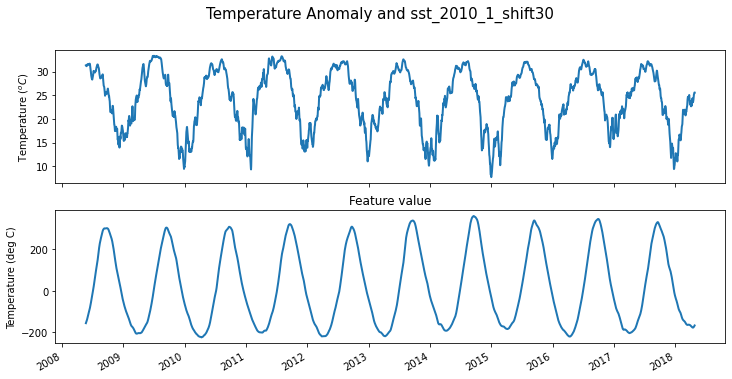

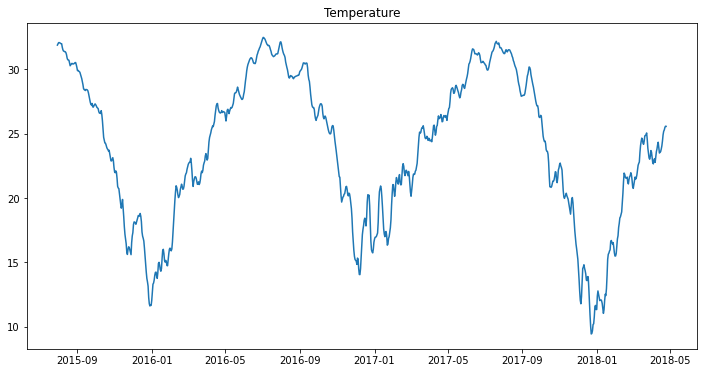

In [6]:
print(Y_train.shape)

colors = sns.color_palette()
c1, c2 = colors[0], colors[1]

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(2, 1, 1)
ax.plot(dates_train,
        Y_train, lw=2, label="training data")
ax.set_ylabel("Temperature ($^oC$)")

ax = fig.add_subplot(2, 1, 2)

feature_str = "sst_2010_1_shift30"
ax.plot(dates_train,
        X_train[:, columnstr_to_index[feature_str]], lw=2, label="training data")
ax.set_ylabel("Temperature Anomaly (deg C)" if is_predicting_anomaly else "Temperature (deg C)")
ax.set_title("Feature value")
fig.suptitle(f"Temperature Anomaly and {feature_str}" if is_predicting_anomaly else 
             f"Temperature Anomaly and {feature_str}",
             fontsize=15)
fig.autofmt_xdate()

plt.figure(figsize=(12, 6))
plt.title(f"Temperature Anomaly" if is_predicting_anomaly else f"Temperature")
plt.plot(dates_train[-1000:], Y_train[-1000:])


In [12]:
def build_model(observed_time_series):
    weekly = tfp.sts.Seasonal(
        num_seasons=26, 
        observed_time_series=observed_time_series,
        num_steps_per_season=14, 
        name='biweekly'
    )
#     seasonal = tfp.sts.Seasonal(
#         num_seasons=4, 
#         observed_time_series=observed_time_series,
#         num_steps_per_season=91, 
#         name='seasonal'
#     )
#     monthly = tfp.sts.Seasonal(
#         num_seasons=12,
#         observed_time_series=observed_time_series,
#         num_steps_per_season=[31, 28, 31, 30, 30, 31, 31, 31, 30, 31, 30, 31],
#         drift_scale_prior=tfd.LogNormal(loc=-1., scale=0.1),
#         initial_effect_prior=tfd.Normal(loc=0., scale=5.),
#         name='month_of_year',
#     )
#     features_effect = tfp.sts.DynamicLinearRegression(
#         design_matrix=X - np.mean(X), 
#         name='other_features'
#     )   
#     autoregressive = tfp.sts.Autoregressive(
#         order=1,
#         observed_time_series=observed_time_series,
#         name='autoregressive'
#     )
#     semilocal = tfp.sts.SemiLocalLinearTrend()
    model = tfp.sts.Sum([
        weekly
#         seasonal,
#         monthly,
#         features_effect,
#         autoregressive
#         semilocal

        ],
        observed_time_series=observed_time_series
    )
    return model

temperature_model = build_model(Y_train)

variational_posteriors = tfp.sts.build_factored_surrogate_posterior(model=temperature_model)
print(variational_posteriors)

tfp.distributions.JointDistributionNamed("build_factored_surrogate_posterior_JointDistributionNamed", batch_shape={biweekly/_drift_scale: [], observation_noise_scale: []}, event_shape={biweekly/_drift_scale: [], observation_noise_scale: []}, dtype={biweekly/_drift_scale: float32, observation_noise_scale: float32})


50
99.82067465782166 seconds


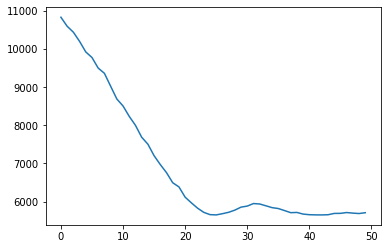

In [13]:
# Allow external control of optimization to reduce test runtimes.
num_variational_steps = 50
print(num_variational_steps)

optimizer = tf.optimizers.Adam(learning_rate=.1)

# Using fit_surrogate_posterior to build and optimize the variational loss function.
@tf.function(experimental_compile=True)
def train():
  elbo_loss_curve = tfp.vi.fit_surrogate_posterior(
    target_log_prob_fn=temperature_model.joint_log_prob(
        observed_time_series=Y_train),
    surrogate_posterior=variational_posteriors,
    optimizer=optimizer,
    num_steps=num_variational_steps)
  return elbo_loss_curve

start = time.time()
elbo_loss_curve = train()
end = time.time()
print(f"{end - start} seconds")
plt.plot(elbo_loss_curve)
plt.show()

In [14]:
print(elbo_loss_curve)

tf.Tensor(
[10829.482  10594.052  10438.255  10198.419   9920.608   9774.549
  9497.498   9360.723   9023.672   8687.736   8504.256   8231.936
  7997.9385  7686.2705  7503.976   7201.473   6969.2656  6757.2974
  6493.084   6384.1978  6114.988   5966.3193  5827.0576  5717.5513
  5657.571   5650.4795  5681.98    5718.66    5775.582   5854.208
  5881.6753  5947.905   5936.6357  5889.0825  5840.9316  5817.27
  5763.8315  5709.123   5714.983   5671.714   5655.8105  5651.0366
  5650.1973  5654.671   5689.236   5691.123   5712.464   5697.227
  5686.5933  5708.1323], shape=(50,), dtype=float32)


In [15]:
# Draw samples from the variational posterior.
q_samples_temperature_ = variational_posteriors.sample(50)


print("Inferred parameters:")
for param in temperature_model.parameters:
  print("{}: {} +- {}".format(param.name,
                              np.mean(q_samples_temperature_[param.name], axis=0),
                              np.std(q_samples_temperature_[param.name], axis=0)))


Inferred parameters:
observation_noise_scale: 1.093071460723877 +- 0.011989990249276161
biweekly/_drift_scale: 3.037395715713501 +- 0.147020623087883


## Forecasting

In [16]:
start = time.time()
temperature_forecast_dist = tfp.sts.forecast(
    model=temperature_model,
    observed_time_series=Y_train[-10 * 365:],
    parameter_samples=q_samples_temperature_,
    num_steps_forecast=num_forecast_steps)
end = time.time()
print(f"time elapsed = {end - start}")

time elapsed = 64.81014943122864


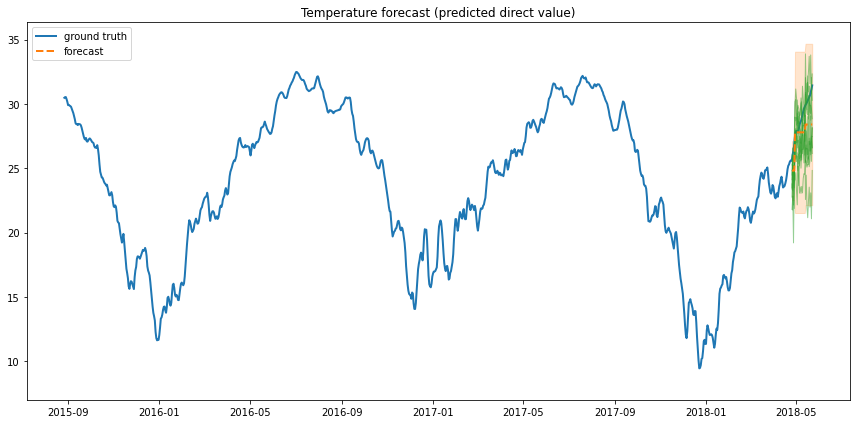

In [17]:
num_samples=10

(
    temperature_forecast_mean,
    temperature_forecast_scale,
    temperature_forecast_samples
) = (
    temperature_forecast_dist.mean().numpy()[..., 0],
    temperature_forecast_dist.stddev().numpy()[..., 0],
    temperature_forecast_dist.sample(num_samples).numpy()[..., 0]
    )

if is_predicting_anomaly:
    fig, ax = plot_forecast(dates, anoms + clims,
                            temperature_forecast_mean + clims_test,
                            temperature_forecast_scale,
                            temperature_forecast_samples + clims_test,
                            title="Temperature forecast (predicted anomaly)",
                            plot_num=1000,
    )
else:
    fig, ax = plot_forecast(dates, temps,
                            temperature_forecast_mean,
                            temperature_forecast_scale,
                            temperature_forecast_samples,
                            title="Temperature forecast (predicted direct value)",
                            plot_num=1000,
    )

fig.tight_layout()


In [18]:
num_to_plot_for_decomp = 10 * 365
# Get the distributions over component outputs from the posterior marginals on
# training data, and from the forecast model.
component_dists = tfp.sts.decompose_by_component(
    temperature_model,
    observed_time_series=Y_train[-num_to_plot_for_decomp:],
    parameter_samples=q_samples_temperature_
)

forecast_component_dists = tfp.sts.decompose_forecast_by_component(
    temperature_model,
    forecast_dist=temperature_forecast_dist,
    parameter_samples=q_samples_temperature_
)


temperature_component_means_, temperature_component_stddevs_ = (
    {k.name: c.mean() for k, c in component_dists.items()},
    {k.name: c.stddev() for k, c in component_dists.items()}
)

temperature_forecast_component_means_, temperature_forecast_component_stddevs_ = (
    {k.name: c.mean() for k, c in forecast_component_dists.items()},
    {k.name: c.stddev() for k, c in forecast_component_dists.items()}
)


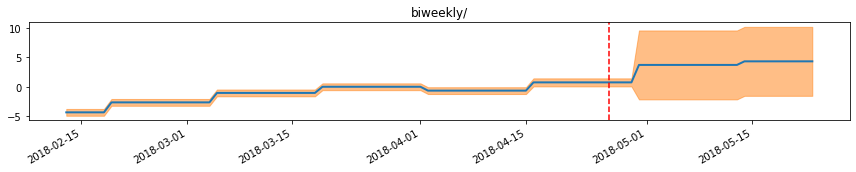

In [20]:
# Concatenate the training data with forecasts for plotting.
component_with_forecast_means_ = collections.OrderedDict()
component_with_forecast_stddevs_ = collections.OrderedDict()
    
for k in temperature_component_means_.keys():
    component_with_forecast_means_[k] = np.concatenate([
        temperature_component_means_[k],
        temperature_forecast_component_means_[k]
    ], axis=-1)
    component_with_forecast_stddevs_[k] = np.concatenate([
        temperature_component_stddevs_[k],
        temperature_forecast_component_stddevs_[k]
    ], axis=-1)

fig, axes = plot_components(
    dates[-num_to_plot_for_decomp:],
    component_with_forecast_means_,
    component_with_forecast_stddevs_,
    vals_to_plot = 100
)
for ax in axes.values():
  ax.axvline(dates.to_numpy()[-num_forecast_steps], linestyle="--", color='red')


In [ ]:
print(num_data_to_consider)